<a href="https://colab.research.google.com/github/Lenflammeur/UCL-MSc_Project/blob/main/TCN_TimeSeries_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load Library

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tqdm.notebook import tqdm
import tensorflow as tf

from tcn import TCN

To monitor training progress and compare evaluation metrics for different models, I use the function below to plot metrics captured from the training job such as training and validation loss or accuracy.

In [2]:
def plot_curves(train_data, val_data, label='Accuracy'):
    """Plot training and validation metrics on single axis.

    Args:
        train_data: list, metrics obtrained from training data.
        val_data: list, metrics obtained from validation data.
        label: str, title and label for plot.
    Returns:
        Matplotlib plot.
    """
    plt.plot(np.arange(len(train_data)) + 0.5,
             train_data,
             "b.-", label="Training " + label)
    plt.plot(np.arange(len(val_data)) + 1,
             val_data, "r.-",
             label="Validation " + label)
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel(label)
    plt.grid(True)  

### Read the dataset


In [3]:
df = pd.read_csv('all_stocks_5yr.csv', delimiter=',')

## APPLE Stock

In [4]:
df_AAPL = df.query("Name == 'AAPL'")
df_AAPL.shape

(1259, 7)

### Display top5 Record

In [5]:
df_AAPL.head()

,date,open,high,low,close,volume,Name
1259,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1260,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
1261,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
1262,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
1263,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL


In [6]:
pd.options.plotting.backend = "plotly"
df_AAPL.plot(x='date', y='close')

### Split the data

I am going to use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons:

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [7]:
column_indices = {name: i for i, name in enumerate(df_AAPL.columns)}

n = len(df_AAPL)
train_df = df_AAPL[0:int(n*0.7)]
val_df = df_AAPL[int(n*0.7):int(n*0.9)]
test_df = df_AAPL[int(n*0.9):]

num_features = df.shape[1]

In [8]:
close_aapl_train = train_df['close'].values
close_aapl_val = val_df['close'].values
close_aapl_test = test_df['close'].values
print("Shapes:")
print("train", close_aapl_train.shape)
print("val", close_aapl_val.shape)
print("test",close_aapl_test.shape)

Shapes:
train (881,)
val (252,)
test (126,)


### Lookback 12 days windows

In [9]:
lookback_window = 12 

In [10]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)


In [11]:
X_train, y_train = split_sequence(close_aapl_train, lookback_window)
X_val, y_val = split_sequence(close_aapl_val, lookback_window)
X_test, y_test = split_sequence(close_aapl_test, lookback_window)

In [12]:
print(X_train.shape)
print(y_train.shape)

(869, 12)
(869,)


### TCN AE

In [13]:
from tensorflow import keras
from tensorflow.keras.layers import UpSampling1D, Conv1D, Reshape

In [14]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[12, 1]))
model.add(TCN())
model.add(keras.layers.Reshape((64, 1), input_shape=(64, )))
model.add(keras.layers.Conv1D(filters=1, kernel_size=1, activation='relu', input_shape=(1, 1)))

#model.add(keras.layers.Dense(1, activation='linear'))
model.add(keras.layers.AveragePooling1D(pool_size=64))
model.add(keras.layers.UpSampling1D(12))
model.add(TCN())
model.add(keras.layers.Reshape((64, 1), input_shape=(64, )))
model.add(keras.layers.Conv1D(filters=1, kernel_size=1, activation='relu', input_shape=(64, 1)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(12, activation='linear'))
model.add(keras.layers.Reshape((12, 1), input_shape=(12, )))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 64)                136256    
_________________________________________________________________
reshape (Reshape)            (None, 64, 1)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 64, 1)             2         
_________________________________________________________________
average_pooling1d (AveragePo (None, 1, 1)              0         
_________________________________________________________________
up_sampling1d (UpSampling1D) (None, 12, 1)             0         
_________________________________________________________________
tcn_1 (TCN)                  (None, 64)                136256    
_________________________________________________________________
reshape_1 (Reshape)          (None, 64, 1)             0

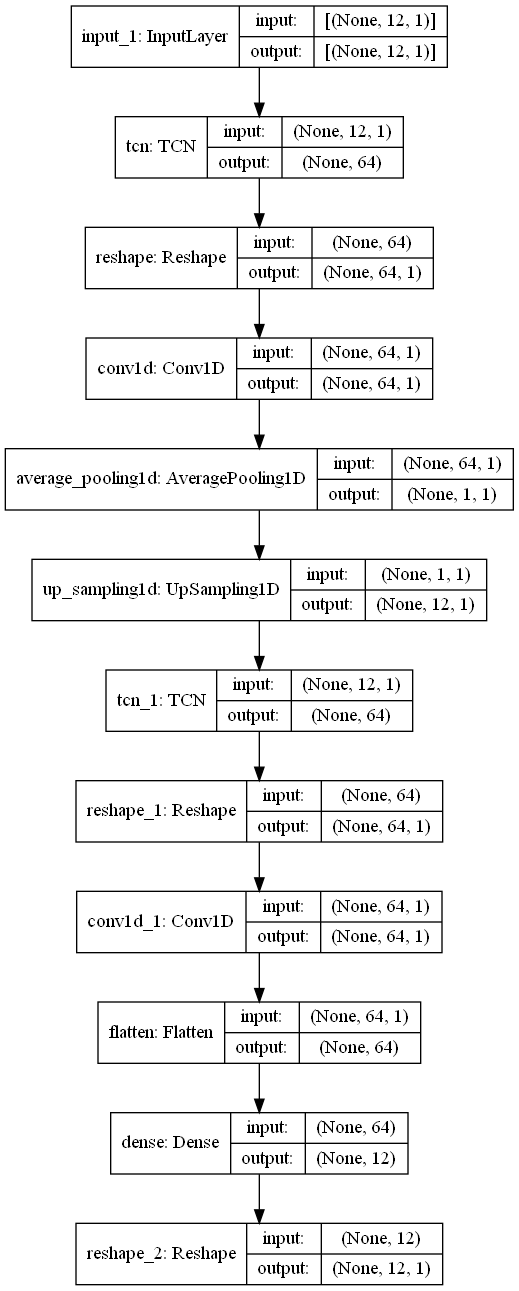

In [15]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [16]:
model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

### Time for Model training...

In [17]:
print('Train...')
history = model.fit(X_train,
                    y_train, 
                    epochs=5,
                    validation_data=(X_val, y_val))

Train...
Epoch 1/5
28/28 [==============================] - 7s 86ms/step - loss: 211578.0280 - mean_absolute_error: 211.2018 - val_loss: 529.9172 - val_mean_absolute_error: 16.9139
Epoch 2/5
28/28 [==============================] - 1s 42ms/step - loss: 148.8933 - mean_absolute_error: 8.4817 - val_loss: 26.2119 - val_mean_absolute_error: 4.1533
Epoch 3/5
28/28 [==============================] - 1s 39ms/step - loss: 11.8180 - mean_absolute_error: 2.6338 - val_loss: 7.2770 - val_mean_absolute_error: 2.0822
Epoch 4/5
28/28 [==============================] - 1s 40ms/step - loss: 5.6763 - mean_absolute_error: 1.8208 - val_loss: 5.0154 - val_mean_absolute_error: 1.6326
Epoch 5/5
28/28 [==============================] - 1s 41ms/step - loss: 5.1407 - mean_absolute_error: 1.7021 - val_loss: 6.0141 - val_mean_absolute_error: 1.9010


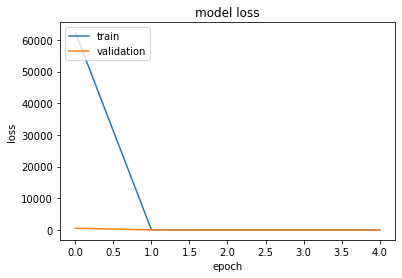

In [18]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Prediction with TCN Model

In [19]:
predict = model.predict(X_test)

### Plot the Result

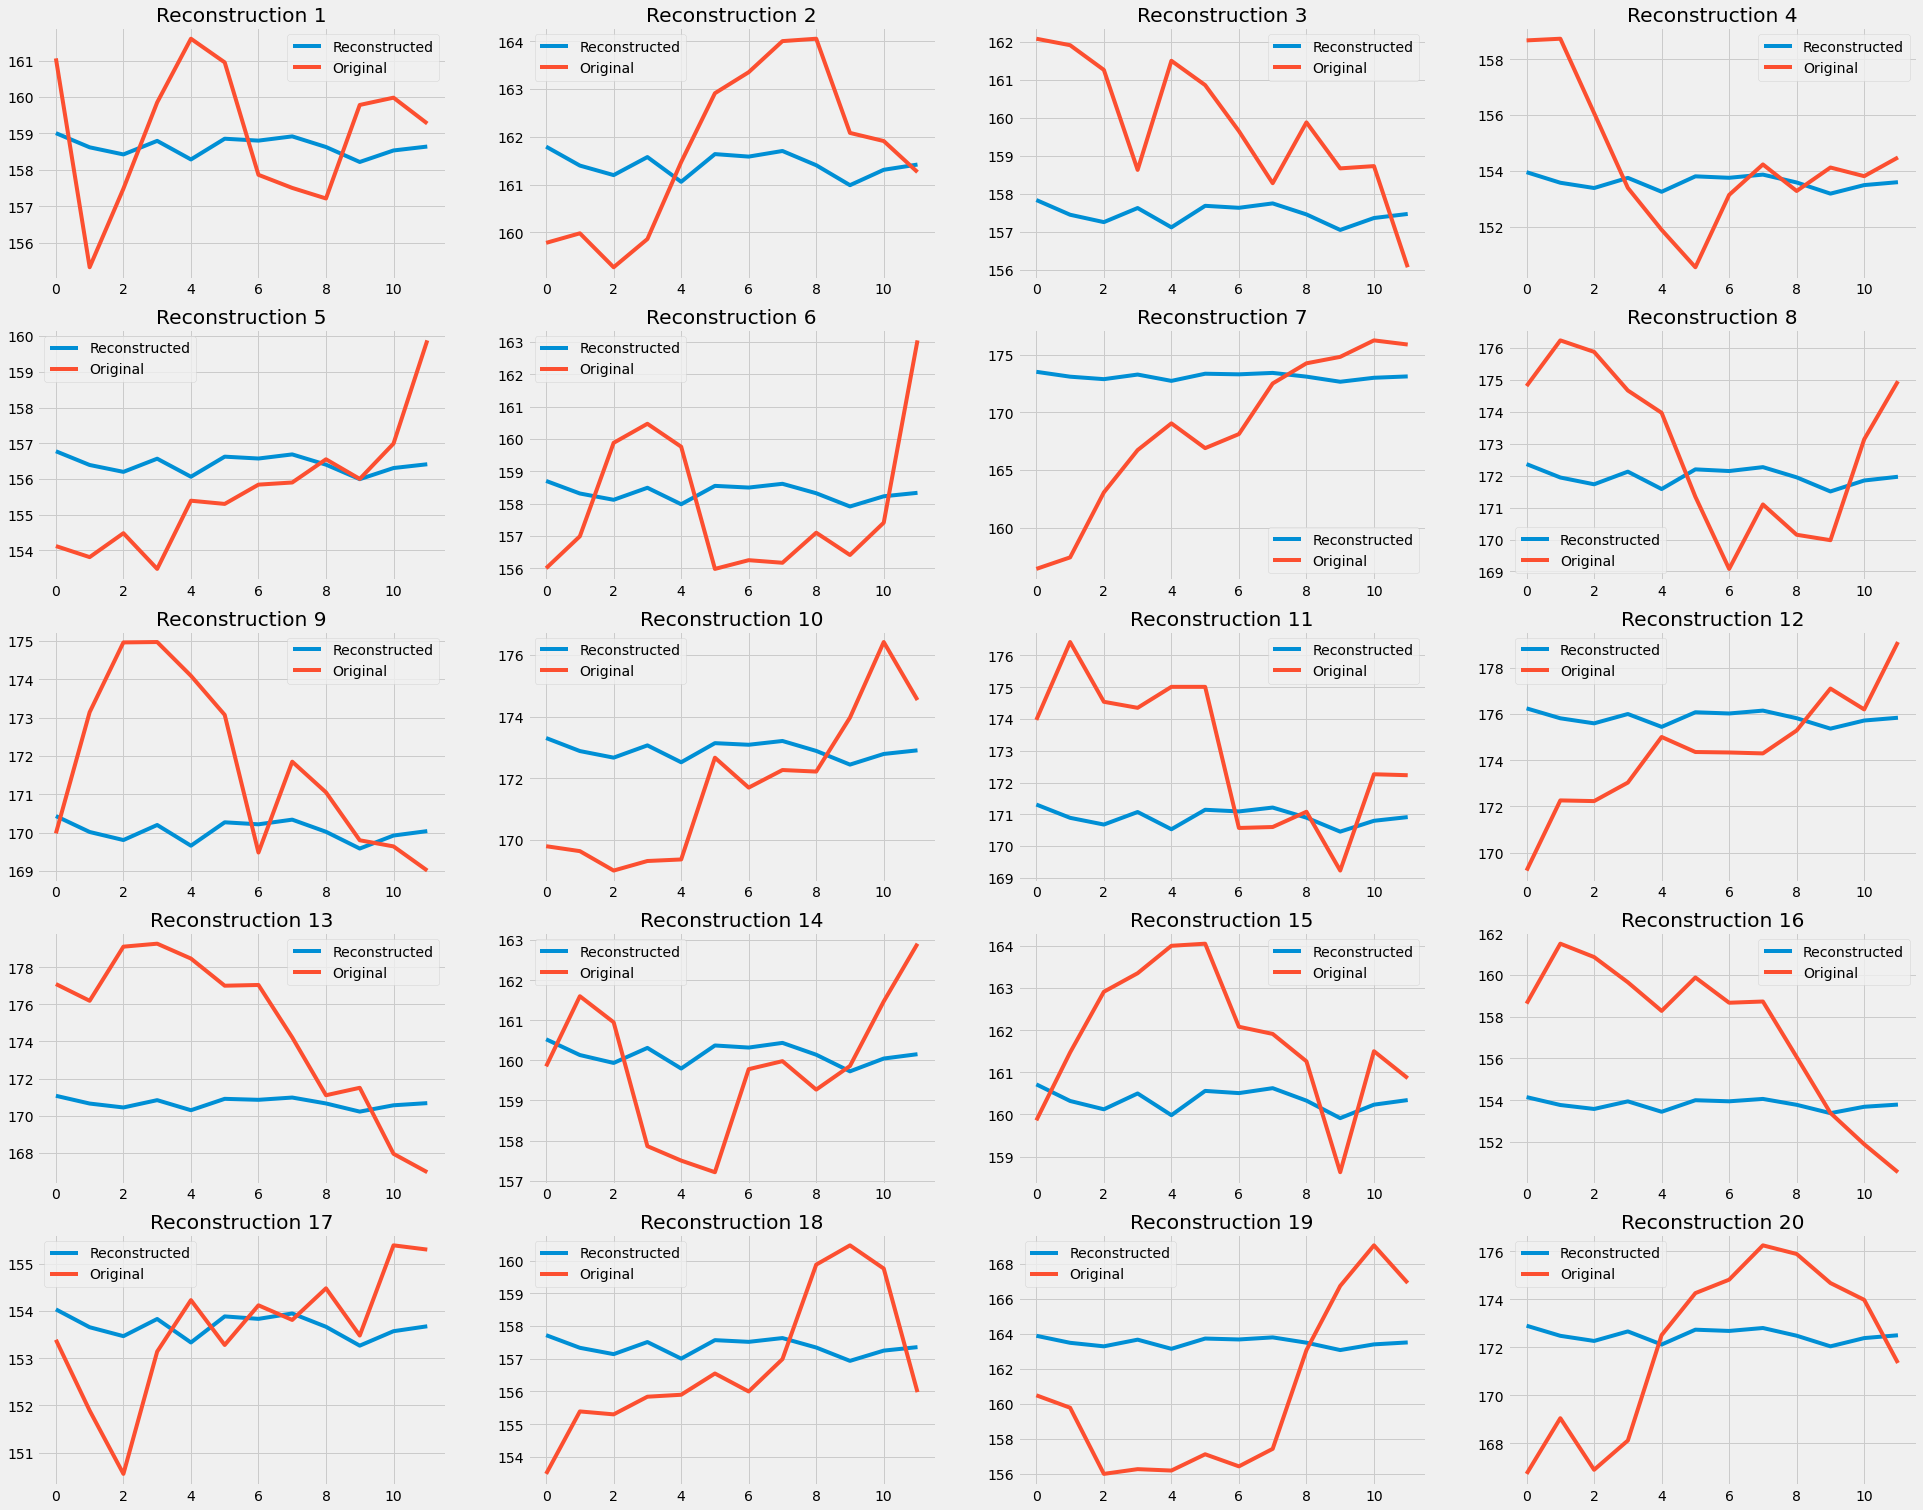

In [20]:
plt.style.use("fivethirtyeight")
axes = plt.subplots(5, 4, figsize = (30, 25))[1]
for i, ax in enumerate(axes.flatten()):
    ax.plot(predict[(9*i)%114])
    ax.plot(X_test[(9*i)%114])
    ax.set_title('Reconstruction {}'.format(i+1))
    ax.legend(['Reconstructed', 'Original'])
plt.show()